# Data Preprocessing

## Read in Our Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
df = pd.read_csv('data/final_subset.csv')
df = df.drop(columns = 'Unnamed: 0')
df.head()

,track_popularity,playlist_genre,playlist_subgenre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,duration_ms,Hit or Not,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,artist_past_performance
0,0,3,14,0.845,0.652,-7.504,0.216,0.00432,0.007230,0.4890,...,111.904,262467,1,0.460365,0.150858,0,4.374450,420,96.012070,7
1,70,3,23,0.496,0.639,-6.157,0.055,0.28000,0.000000,0.0975,...,147.764,224720,1,0.609292,0.232474,0,3.745333,359,95.852617,0
2,52,3,14,0.764,0.594,-10.050,0.185,0.59100,0.000000,0.1450,...,87.261,286441,1,0.590514,0.200076,0,4.774017,634,132.802218,2
3,72,4,6,0.865,0.657,-6.722,0.076,0.04040,0.000000,0.1400,...,111.115,268960,1,0.409803,0.013691,3,4.482667,722,161.064842,8
4,8,3,9,0.662,0.748,-3.041,0.268,0.68800,0.000008,0.0841,...,82.331,239027,1,0.737900,0.459439,7,3.983783,554,139.063788,0


In [3]:
df.shape

(7358, 21)

## Normalization (If Necessary)

In [4]:
def z_score_norm_df(daf):
    """
    A helper function that z-score normalizes the columns of
    DataFrame daf and returns those normalized columns in a
    new DataFrame df_norm; thus, this does not mutate daf.
    """
    nrows, ncols = daf.shape
    cols = list(daf.columns.values)
    mat = daf.to_numpy()
    mat_norm = np.zeros((nrows, ncols))
    for i in range(ncols):
        mean = mat[:,i].mean()
        std = mat[:,i].std()
        mat_norm[:,i] = (mat[:,i] - mean) / std
    df_norm = pd.DataFrame(mat_norm, columns = cols)
    return df_norm

In [5]:
def min_max_norm_df(daf):
    """
    A helper function that min-max normalizes the columns of
    DataFrame daf and returns those normalized columns in a
    new DataFrame df_norm; thus, this does not mutate daf.
    """
    nrows, ncols = daf.shape
    cols = list(daf.columns.values)
    mat = daf.to_numpy()
    mat_norm = np.zeros((nrows, ncols))
    for i in range(ncols):
        maximum = np.max(mat[:,i])
        minimum = np.min(mat[:,i])
        mat_norm[:,i] = (mat[:,i] - minimum) / (maximum - minimum)
    df_norm = pd.DataFrame(mat_norm, columns = cols)
    return df_norm

## Split Data into Training and Test Sets 

In [6]:
from sklearn.model_selection import train_test_split

y = df['Hit or Not']
X = df.drop(columns = 'Hit or Not')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelling

## Model Imports 

In [7]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Hyperparameter Tuning and Accuracy Metric Imports

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

## Support Vector Machine

Here, I will try to fit an SVM to the data. I will start by using all the features, and then I will experiment with subsets of features and see how they impact the results.

Fitting 4 folds for each of 160 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 10.2min finished


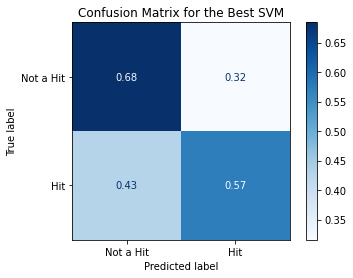

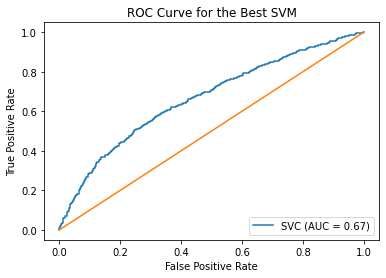

In [9]:
X_train_norm = z_score_norm_df(X_train)
X_test_norm = z_score_norm_df(X_test)

params1 = {'C':[0.01,0.1,1,10,100],
          'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
          'degree':[2,3,4,5],
          'gamma':['scale', 'auto']}

svm_clf = SVC()
grid_search1 = GridSearchCV(estimator = svm_clf, param_grid = params1, cv = 4, n_jobs = -1, verbose = 2)
grid_search1.fit(X_train_norm, y_train)
best_grid1 = grid_search1.best_estimator_

title = 'Confusion Matrix for the Best SVM'
disp = plot_confusion_matrix(best_grid1, X_test_norm, y_test,
                                 display_labels=['Not a Hit', 'Hit'],
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
disp.ax_.set_title(title)
roc = plot_roc_curve(best_grid1, X_test_norm, y_test)
roc.ax_.set_title('ROC Curve for the Best SVM')
plt.plot(np.linspace(0,1,1000), np.linspace(0,1,1000))
plt.show()

In [10]:
grid_search1.best_params_

{'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

## Random Forest Binary Classification

Here, I will try to fit a random forest model to the data. I can be a little more lenient with which features I use since random forest will average the performance of the randomly generated trees based on random sets of features.

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  1.7min finished


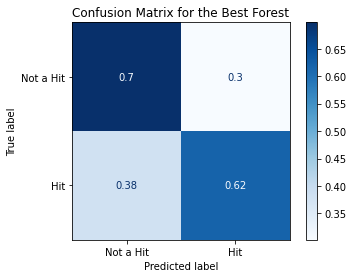

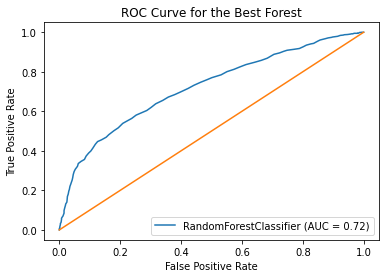

In [11]:
params2 = {'bootstrap':[True],
         'max_depth':[3,4,5,None],
         'max_features':['auto', 6, 8, 10],
         'min_samples_leaf':[1],
         'min_samples_split':[2],
         'n_estimators':[80,110,140,170]}

forest_clf = RandomForestClassifier()
grid_search2 = GridSearchCV(estimator = forest_clf, param_grid = params2, cv = 4, n_jobs = -1, verbose = 2)
grid_search2.fit(X_train, y_train)
best_grid2 = grid_search2.best_estimator_

title = 'Confusion Matrix for the Best Forest'
disp = plot_confusion_matrix(best_grid2, X_test, y_test,
                                 display_labels=['Not a Hit', 'Hit'],
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
disp.ax_.set_title(title)
roc = plot_roc_curve(best_grid2, X_test, y_test)
roc.ax_.set_title('ROC Curve for the Best Forest')
plt.plot(np.linspace(0,1,1000), np.linspace(0,1,1000))
plt.show()

In [12]:
print(best_grid2.feature_importances_)
print(X_train.columns)

[0.06040526 0.02116721 0.03707313 0.05259318 0.04976363 0.05156013
 0.0736256  0.05516017 0.03868139 0.05299179 0.06067767 0.05606813
 0.05810052 0.05307563 0.0617572  0.02494037 0.05757919 0.05144104
 0.05138378 0.03195498]
Index(['track_popularity', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'lyrical_subjectivity', 'lyrical_polarity', 'repeated_phrases',
       'minutes', 'word_count', 'WPM_approx', 'artist_past_performance'],
      dtype='object')


In [13]:
grid_search2.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 140}

### Create a Dataset of Incorrectly Classified Songs to see Similarities Between Their Features

In [14]:
y_pred = best_grid2.predict(X_test)
comparison = X_test.copy()
comparison['correct'] = (y_pred == y_test.to_numpy())
comparison.head()

,track_popularity,playlist_genre,playlist_subgenre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,duration_ms,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,artist_past_performance,correct
1893,76,2,17,0.459,0.891,-5.057,0.0623,0.00511,0.00000,0.1060,...,154.837,203507,0.531820,0.255952,9,3.391783,668,196.946542,0,True
4385,80,4,8,0.732,0.627,-5.693,0.1610,0.34600,0.00000,0.2610,...,81.481,135460,0.536957,-0.103011,0,2.257667,405,179.388749,0,True
6821,35,5,0,0.610,0.825,-9.316,0.0515,0.11700,0.00238,0.1530,...,129.300,176907,0.599333,-0.029333,0,2.948450,259,87.842765,0,True
6825,6,1,11,0.937,0.565,-10.325,0.0955,0.09440,0.00000,0.0928,...,130.012,165040,0.576539,0.332893,0,2.750667,513,186.500242,0,True
1669,56,3,9,0.699,0.668,-5.305,0.1060,0.26500,0.00000,0.1410,...,83.074,254467,0.582977,0.107423,0,4.241117,822,193.816880,6,False


In [15]:
incorrect = comparison[comparison['correct'] != True]
print(comparison.shape, incorrect.shape)
incorrect.head()

(2208, 21) (754, 21)


,track_popularity,playlist_genre,playlist_subgenre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,duration_ms,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,artist_past_performance,correct
1669,56,3,9,0.699,0.668,-5.305,0.1060,0.2650,0.000000,0.1410,...,83.074,254467,0.582977,0.107423,0,4.241117,822,193.816880,6,False
95,38,2,3,0.645,0.578,-6.818,0.0390,0.0171,0.000000,0.0815,...,97.950,181905,0.429514,0.030556,0,3.031750,236,77.842830,0,False
468,23,2,10,0.281,0.654,-7.765,0.0359,0.2680,0.000478,0.0631,...,172.009,206613,0.748413,-0.236508,0,3.443550,129,37.461341,0,False
230,60,3,23,0.642,0.284,-15.317,0.0326,0.8450,0.000234,0.1130,...,147.874,310000,0.571739,0.096739,0,5.166667,209,40.451613,0,False
763,6,3,14,0.783,0.580,-7.398,0.2980,0.0817,0.000000,0.0831,...,93.026,284360,0.303125,0.108854,17,4.739333,646,136.306091,5,False


In [16]:
incorrect.to_csv('data/rf_incorrect.csv')

## Gradient Boosted Trees 

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  8.2min finished


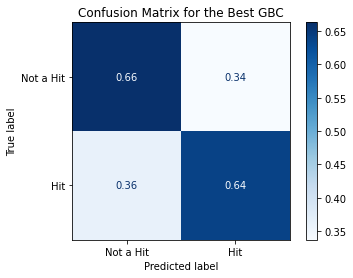

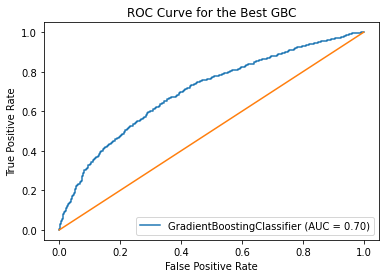

In [17]:
params3 = {'loss':['deviance', 'exponential'],
           'learning_rate':[0.01,0.1,1,10],
           'n_estimators':[600,700,800,900]}

gbc_clf = GradientBoostingClassifier()
grid_search3 = GridSearchCV(estimator = gbc_clf, param_grid = params3, cv = 4, n_jobs = -1, verbose = 2)
grid_search3.fit(X_train, y_train)
best_grid3 = grid_search3.best_estimator_

title = 'Confusion Matrix for the Best GBC'
disp = plot_confusion_matrix(best_grid3, X_test, y_test,
                                 display_labels=['Not a Hit', 'Hit'],
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
disp.ax_.set_title(title)
roc = plot_roc_curve(best_grid3, X_test, y_test)
roc.ax_.set_title('ROC Curve for the Best GBC')
plt.plot(np.linspace(0,1,1000), np.linspace(0,1,1000))
plt.show()

In [18]:
print(best_grid3.feature_importances_)
print(X_train.columns)

[0.06987095 0.01159075 0.03786496 0.04588244 0.03908073 0.04269567
 0.09533679 0.04909288 0.0378108  0.05437464 0.06170435 0.06056811
 0.05585004 0.05231933 0.07255329 0.0194688  0.05510786 0.04398473
 0.0448767  0.04996619]
Index(['track_popularity', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'lyrical_subjectivity', 'lyrical_polarity', 'repeated_phrases',
       'minutes', 'word_count', 'WPM_approx', 'artist_past_performance'],
      dtype='object')


In [19]:
grid_search3.best_params_

{'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 600}